<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Soma_Size/Cell_pose_AR_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install cellpose --quiet
from cellpose import models

In [1]:

import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage


In [70]:
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/'
os.chdir(source_directory)

In [2]:



my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))
print(my_tiffs)

curr_tif = my_tiffs[0]

['C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/CA3_a.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/CA3_RGBW_.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/CA3_RGB_Color.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/DG_a.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22__S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-24-22_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-24-22__S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.t

In [3]:
curr_tif = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/CA3_RGBW_.tif'

In [6]:
def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    data_t =data_t.astype('float16')
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def norm_channels(im_data,tiff_format,clip=False):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),[99,1])
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

def med_filt_stack(img,d):
    color_dim = tiff_format.index('c')
    z_dim = tiff_format.index('z')
    color_dim=1
    z_dim=0
    for c in range(img.shape[color_dim]):
        for z in range(img.shape[z_dim]):
            img[z,c,:,:] = skimage.filters.median(img[z,c,:,:],footprint=np.ones([d,d]))
    return img



In [28]:
rgb_stack.shape

(44, 800, 800, 3)

(44, 3, 800, 800)


[]

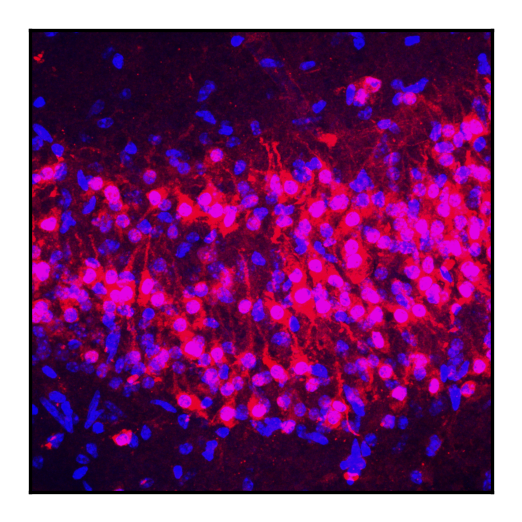

In [40]:
tiff_data_raw = tifffile.imread(curr_tif)
tiff_format = 'zcyx'

tiff_data = med_filt_stack(tiff_data_raw,2)
tiff_data = norm_channels(tiff_data,'zcyx',clip=True)
tiff_data = tiff_data[:,[3,0,2],:,:]
print(tiff_data.shape)
tiff_data[:,1,:,:]=0


rgb_stack = tiff_data.transpose(0,2,3,1)*225
rgb_stack[rgb_stack<0]=0
rgb_stack[rgb_stack>255]=255
rgb_stack=rgb_stack.astype('uint8')

max_proj_rgb = np.max(tiff_data,axis=0).transpose(1,2,0) *225
fig,ax=plt.subplots(1,1,figsize=(2,2),dpi=300)
ax.imshow(max_proj_rgb.astype('uint8'))
ax.set_xticks([])
ax.set_yticks([])




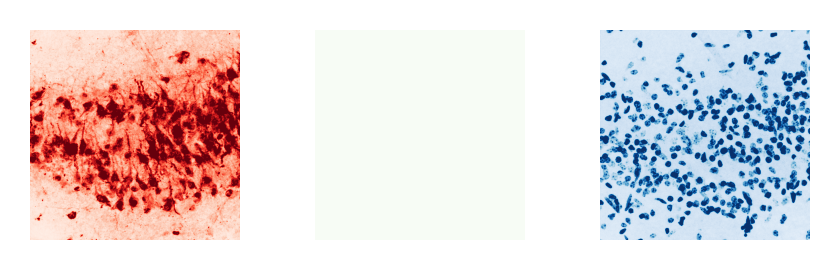

In [41]:
""" Display Split Projections """
num_c = tiff_data.shape[1]
fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
colors = ['Reds','Greens','Blues','gray']
for c in range(num_c):
    ax[c].imshow(np.max(tiff_data[:,c,:,:],axis=0), cmap=colors[c],vmin=0,vmax=1)
    ax[c].axis('off')
plt.tight_layout()

In [ ]:
# colors = ['Reds','Greens','Blues','gray_r']
# for z in range(tiff_data.shape[0]):
#     num_c = tiff_data.shape[1]
#     fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
#     for c in range(num_c):
#         ax[c].imshow(tiff_data[z,c], cmap=colors[c],vmin=0,vmax=1)
#         ax[c].axis('off')
#     plt.tight_layout()
#     plt.show()

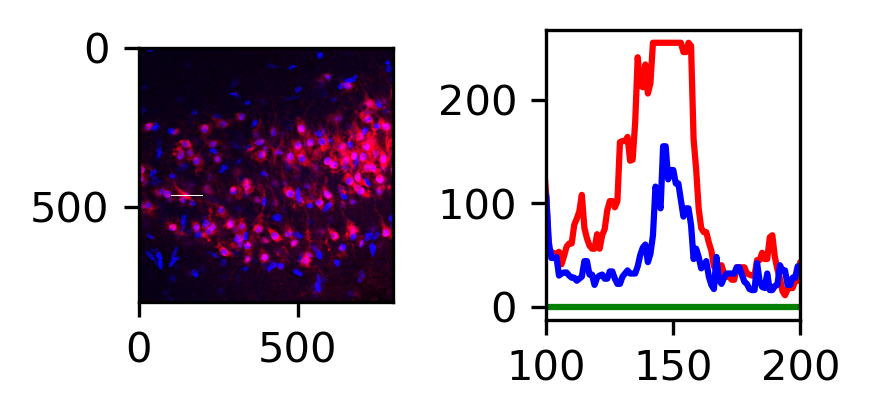

In [42]:
img_rgb = tiff_data.transpose([0,2,3,1])*255
img_rgb[img_rgb>255]=255
img_rgb[img_rgb<0]=0
img_rgb=img_rgb.astype('uint8')
fig,ax =plt.subplots(1,2,figsize=(3,1.5),dpi=300)
ax[0].imshow(img_rgb[27])
y=465
xb=[100,200]
ax[0].plot(xb,[y,y],'w',linewidth=.25)
ax[1].plot(img_rgb[27,y,:,0],color='r')
ax[1].plot(img_rgb[27,y,:,1],color='g')
ax[1].plot(img_rgb[27,y,:,2],color='b')
ax[1].set_xlim(xb)
plt.tight_layout()

In [43]:
""" Define Model """
print(tiff_data.shape)

print('nuclear_channel',nuclear_channel)
print('cell_channel',cell_channel)
model = models.Cellpose(model_type='cyto3')


(44, 3, 800, 800)
nuclear_channel 0
cell_channel 1


In [ ]:
zi = 35
diam = 30
cell_channel = 1
nuclear_channel = 0
channel_axis = 3
(zi_masks, zi_flows, zi_styles, zi_diams) =  model.eval(tiff_data[zi,:,:,:], channels=[cell_channel, nuclear_channel], channel_axis = 0, diameter=diam, do_3D=False) #
fig,ax=plt.subplots(1,figsize=(1.5,1.5),dpi=600)
ax.imshow(img_rgb[zi,:,:,:])
ax.contour(zi_masks,linewidths=.2,cmap='prism')

In [88]:
img_rgb.shape

(44, 800, 800, 3)

In [ ]:
channel_axis=3
(masks, flows, styles, diams) =  model.eval(img_rgb, channels=[cell_channel, nuclear_channel], channel_axis = channel_axis, diameter=diam, do_3D=False,stitch_threshold=0.2) #
fig,ax=plt.subplots(1,figsize=(1.5,1.5),dpi=300)
plt.imshow(np.sum(masks>0,axis=0))

In [ ]:
""" Slice 3d"""
zi = 35
fig,ax=plt.subplots(1,2,figsize=(3,1.5),dpi=800)
ax[0].imshow((tiff_data[zi,:,:,:].transpose(1,2,0)*255).astype('uint'))
ax[0].contour(masks[zi,:,:],linewidths=.2,cmap='gray')

""" no 3d"""
(zi_masks, zi_flows, zi_styles, zi_diams) =  model.eval(tiff_data[zi,:,:,:], channels=[cell_channel, nuclear_channel], channel_axis = 0, diameter=diam, do_3D=False) #
ax[1].imshow(img_rgb[zi,:,:,:])
ax[1].contour(zi_masks,linewidths=.2,cmap='gray')


In [95]:
mask_shuffle=np.zeros_like(masks)
ids = np.arange(np.max(masks))+1
rand_ids = np.random.choice(ids, size=len(ids), replace=False)
for i,ri in enumerate(rand_ids):
    mask_shuffle[masks==i+1] = ri
tifffile.imwrite('./mask_shuffle.tif',mask_shuffle)

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_14876\829875810.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,figsize=(1,1),dpi=300)


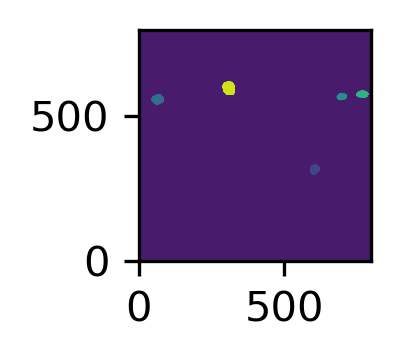

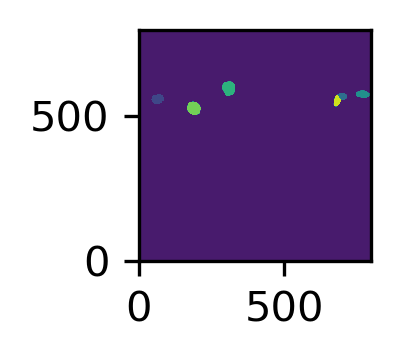

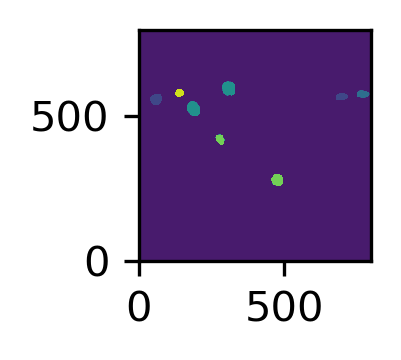

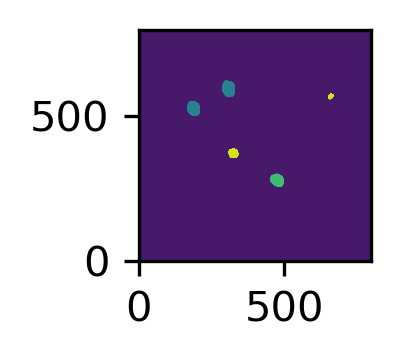

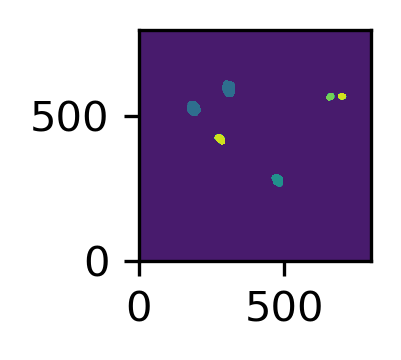

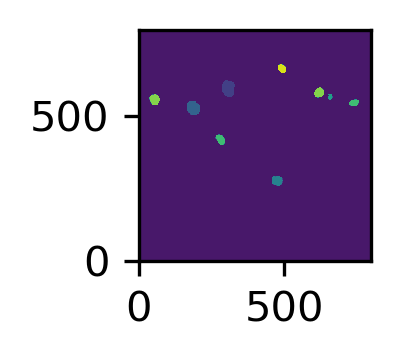

In [ ]:
for zi in range(masks.shape[0]):
    fig,ax=plt.subplots(1,figsize=(1,1),dpi=300)
    ax.contourf(masks[zi,:,:])

In [ ]:
vmax=np.nanmax(masks)
levels = np.arange(vmax+1).astype(int)
print(levels)

NameError: name 'masks' is not defined

In [ ]:
# masks=masks.astype(float)
# masks[masks<1]=np.nan

top = np.nanmax(masks)
masks.shape
num_z = tiff_data.shape[0]
for z in range(num_z):
    fig,ax=plt.subplots(1,2,figsize=(6,2),dpi=300)
    ax[0].imshow(tiff_data[z,cell_channel-1,:,:], cmap='Reds',vmin=0,vmax=1)
    ax[1].imshow(tiff_data[z,nuclear_channel-1,:,:], cmap='Blues',vmin=0,vmax=1)
    # ax[2].imshow(img_rgb[z,:,:])
    # ax[0].contour(masks[z,:,:],linewidths=.2,vmin=0,vmax=vmax,cmap='prism',levels=levels)
    ax[1].contour(masks[z,:,:],linewidths=.2,vmin=0,vmax=vmax,cmap='prism',levels=levels)
    ax[2].contour(masks[z,:,:],linewidths=.2,vmin=0,vmax=vmax,cmap='prism',levels=levels)
    plt.tight_layout


NameError: name 'np' is not defined

In [ ]:
# tiff_data_list = [tiff_data[z,:,:,:] for z in range(tiff_data.shape[0])]

In [ ]:
voxels = [0.2652, 0.2652, 0.6]

In [ ]:
non_zero = masks[~np.isnan(masks)]
num_cells = np.max(non_zero).astype(int)
print(num_cells)
edges = np.arange(0,num_cells)
pxl_counts, ids = np.histogram(masks[~np.isnan(masks)],bins = edges)

size_counts, sizes = np.histogram(np.log10(pxl_counts+1),bins=200)

fig,ax = plt.subplots(1,1,figsize=(2,1),dpi=300)
ax.stairs(size_counts,sizes) #np.cumsum(size_counts)
ax.set_yscale('log')